# Testing GPU access

In [ ]:
!py -0

 -V:3.13 *        Python 3.13 (64-bit)
 -V:3.11          Python 3.11 (64-bit)
 -V:3.10          Python 3.10 (64-bit)


In [ ]:
!conda activate py310

In [ ]:
!python --version

Python 3.10.18


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\uneeb\anaconda3\envs\py310\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [ ]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0)) # Print name of the first GPU
else:
    print("No GPUs available for PyTorch.")

PyTorch version: 2.8.0+cpu
CUDA available: False
No GPUs available for PyTorch.


In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    print("TensorFlow can access the following GPUs:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs found. TensorFlow cannot access a GPU.")

TensorFlow can access the following GPUs:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Importing libraries

In [ ]:
!pip install librosa

In [ ]:
!pip install tensorflow_io

In [ ]:
!pip install seaborn

## Import

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.effects
import soundfile as sf

In [ ]:
import tensorflow_io as tfio
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Reshape, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Preprocessing and Loading Dataset

In [ ]:
ravdess_dir = "D:\ML Projects\Multimodal Emotion Detection\Speech\Ravdess"
tess_dir = "D:\ML Projects\Multimodal Emotion Detection\Speech\TESS"

In [ ]:
def load_ravdess_and_tess(ravdess_dir, tess_dir):
    # consistent label mapping
    label_map = {
        "neutral": 0,
        "calm": 1,
        "happy": 2,
        "sad": 3,
        "angry": 4,
        "fearful": 5,
        "disgust": 6,
        "surprised": 7,
        "pleasant_surprise": 8   # special for TESS
    }

    normalize_map = {
        "fear": "fearful",
        "surprise": "surprised",
        "pleasant": "pleasant_surprise"
    }

    filepaths, labels = [], []

    # -------------------
    # RAVDESS
    # -------------------
    for actor_folder in os.listdir(ravdess_dir):
        folder_path = os.path.join(ravdess_dir, actor_folder)
        if not os.path.isdir(folder_path):
            continue

        for file in os.listdir(folder_path):
            if not file.endswith(".wav"):
                continue

            parts = file.split("-")
            emotion_id = int(parts[2])
            emotion = {
                1: "neutral",
                2: "calm",
                3: "happy",
                4: "sad",
                5: "angry",
                6: "fearful",
                7: "disgust",
                8: "surprised"
            }[emotion_id]

            if emotion in normalize_map:
                emotion = normalize_map[emotion]

            if emotion not in label_map:
                continue

            filepaths.append(os.path.join(folder_path, file))
            labels.append(label_map[emotion])

    # -------------------
    # TESS
    # -------------------
    for emotion_folder in os.listdir(tess_dir):
        folder_path = os.path.join(tess_dir, emotion_folder)
        if not os.path.isdir(folder_path):
            continue

        emotion = emotion_folder.split('_')[-1].lower()
        if emotion in normalize_map:
            emotion = normalize_map[emotion]

        if emotion not in label_map:
            continue

        for file in os.listdir(folder_path):
            if not file.endswith(".wav"):
                continue
            filepaths.append(os.path.join(folder_path, file))
            labels.append(label_map[emotion])

    print(f"✅ Loaded {len(filepaths)} audio files total")
    return filepaths, labels, list(label_map.keys())


In [ ]:
# Check Loading of dataset
filepaths, labels, class_names = load_ravdess_and_tess(ravdess_dir, tess_dir)

print("Classes:", class_names)
print("First 5 samples:", filepaths[:5], labels[:5])


✅ Loaded 4240 audio files total
Classes: ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'pleasant_surprise']
First 5 samples: ['D:\\ML Projects\\Multimodal Emotion Detection\\Speech\\Ravdess\\Actor_01\\03-01-01-01-01-01-01.wav', 'D:\\ML Projects\\Multimodal Emotion Detection\\Speech\\Ravdess\\Actor_01\\03-01-01-01-01-02-01.wav', 'D:\\ML Projects\\Multimodal Emotion Detection\\Speech\\Ravdess\\Actor_01\\03-01-01-01-02-01-01.wav', 'D:\\ML Projects\\Multimodal Emotion Detection\\Speech\\Ravdess\\Actor_01\\03-01-01-01-02-02-01.wav', 'D:\\ML Projects\\Multimodal Emotion Detection\\Speech\\Ravdess\\Actor_01\\03-01-02-01-01-01-01.wav'] [0, 0, 0, 0, 1]


### Data Augmentation

In [ ]:
import random

# Folder to save augmented calm audio
augmented_dir = r"D:\ML Projects\Multimodal Emotion Detection\Speech\Augmented"

if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

def augment_audio(file_path, output_path, sr=16000):
    audio, sr = librosa.load(file_path, sr=sr)

    # Randomly choose augmentation
    choice = random.choice(["pitch", "speed", "noise", "shift"])

    if choice == "pitch":
      audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=random.uniform(-2, 2))
    elif choice == "speed":
        speed = random.uniform(0.9, 1.1)
        audio = librosa.effects.time_stretch(audio, rate=speed)
    elif choice == "noise":
        noise = np.random.normal(0, 0.005, audio.shape)
        audio = audio + noise
    elif choice == "shift":
        shift_range = int(0.1 * sr)  # shift by up to 0.1 sec
        shift = np.random.randint(-shift_range, shift_range)
        audio = np.roll(audio, shift)

    sf.write(output_path, audio, sr)

def balance_calm_class(filepaths, labels, target_count=592, sr=16000):
    calm_class_index = class_names.index("calm")

    calm_files = [f for f, l in zip(filepaths, labels) if l == calm_class_index]
    current_count = len(calm_files)

    print(f"Calm before augmentation: {current_count}")

    i = 0
    while len(calm_files) < target_count:
        original_file = random.choice(calm_files)
        augmented_file = os.path.join(augmented_dir, f"calm_aug_{i}.wav")

        augment_audio(original_file, augmented_file, sr=sr)

        calm_files.append(augmented_file)
        filepaths = np.append(filepaths, augmented_file)
        labels = np.append(labels, calm_class_index)
        i += 1

    print(f"Calm after augmentation: {len(calm_files)}")
    return filepaths, labels

In [ ]:
filepaths, labels = balance_calm_class(filepaths, labels, target_count=350, sr=16000)


Calm before augmentation: 192
Calm after augmentation: 350


### Convert to Spectograms

In [ ]:
SR = 16000      # sampling rate
DURATION = 3    # seconds
N_MELS = 64

# Convert audio file → mel spectrogram
def decode_audio(file_path):
    # file_path is a Tensor here, so convert it to a Python string
    file_path = file_path.numpy().decode("utf-8")

    # Load audio
    audio, _ = librosa.load(file_path, sr=SR)

    # Pad or trim to fixed length
    max_len = SR * DURATION
    if len(audio) > max_len:
        audio = audio[:max_len]
    else:
        audio = np.pad(audio, (0, max_len - len(audio)))

    # Convert to mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SR, n_mels=N_MELS, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize between 0 and 1
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    return mel_spec_db.astype(np.float32)

def preprocess(file_path, label):
    mel_spec = tf.py_function(func=decode_audio, inp=[file_path], Tout=tf.float32)
    mel_spec.set_shape((N_MELS, None))  # Set shape for TF to know dimensions
    mel_spec = tf.expand_dims(mel_spec, -1)  # Add channel dimension
    return mel_spec, label


In [ ]:
from collections import Counter

label_counts = Counter(labels)

# Print the number of instances for each class
print("Number of instances for each class:")
for label_index in sorted(label_counts.keys()):
    class_name = class_names[label_index]
    count = label_counts[label_index]
    print(f"- {class_name}: {count}")

Number of instances for each class:
- neutral: 496
- calm: 350
- happy: 592
- sad: 592
- angry: 592
- fearful: 592
- disgust: 592
- surprised: 592


### Test train Split

In [ ]:
# convert lists to numpy arrays
filepaths = np.array(filepaths)
labels = np.array(labels)

train_files, val_files, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [ ]:
BATCH_SIZE = 32

# Train Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# Validation Dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


In [ ]:
# Accounting for class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert class weights to a dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)


Class weights: {0: 1.108366935483871, 1: 1.5707142857142857, 2: 0.9286317567567568, 3: 0.9286317567567568, 4: 0.9286317567567568, 5: 0.9286317567567568, 6: 0.9286317567567568, 7: 0.9286317567567568}


# Build Model

### Model 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Reshape, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(N_MELS, int(SR * DURATION / 512) + 1, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Reshape((-1, 64)),   # reshape for GRU (time_steps, features)

    GRU(128, return_sequences=False),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(len(class_names), activation='softmax')  # for multiclass classification
])

model1.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 94, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 64, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 32, 47, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 47, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 47, 64)      

In [ ]:
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Training
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1

)

Epoch 1/100
 38/110 [=========>....................] - ETA: 48s - loss: 2.2986 - accuracy: 0.1661

KeyboardInterrupt: 

In [ ]:
""""model1.save('D:\JN\Multimodal Expression\Audio\emotion_audio_m1.h5')
print("Model saved successfully!")""""

In [ ]:
# Load the model
model1 = tf.keras.models.load_model('D:\JN\Multimodal Expression\Audio\emotion_audio_m1.h5')
print("Model 'emotion_audio_m1.h5' loaded successfully!")

# Optional: Display model summary to verify
model1.summary()

Model 'emotion_audio_m1.h5' loaded successfully!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 94, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 47, 64)        18496     
                                                                 
 batch_

In [ ]:
train_loss, train_acc = model1.evaluate(train_ds, verbose=1)
print(f"✅ Train Loss: {train_loss:.4f}")
print(f"✅ Train Accuracy: {train_acc:.4f}")

test_loss, test_acc = model1.evaluate(val_ds, verbose=1)
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

110/110 [==============================] - 2s 13ms/step - loss: 0.3317 - accuracy: 0.9014
✅ Train Loss: 0.3317
✅ Train Accuracy: 0.9014
28/28 [==============================] - 0s 15ms/step - loss: 0.3745 - accuracy: 0.8818
✅ Test Loss: 0.3745
✅ Test Accuracy: 0.8818


In [ ]:
# Classification Report for Test Set

from sklearn.metrics import classification_report

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

predictions = model1.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

unique_labels = np.unique(true_labels)

target_names_subset = [class_names[i] for i in unique_labels]

# Calculate and print classification report
report = classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=target_names_subset)
print("Classification Report:")
print(report)

28/28 [==============================] - 1s 21ms/step
Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.91      0.90        99
        calm       0.76      0.73      0.74        70
       happy       0.91      0.84      0.87       118
         sad       0.79      0.86      0.82       118
       angry       0.92      0.91      0.92       119
     fearful       0.92      0.89      0.91       119
     disgust       0.92      0.95      0.93       119
   surprised       0.89      0.92      0.90       118

    accuracy                           0.88       880
   macro avg       0.88      0.87      0.88       880
weighted avg       0.88      0.88      0.88       880



In [ ]:
# Classification Report for Train Set

train_true_labels = np.concatenate([y for x, y in train_ds], axis=0)

train_predictions = model1.predict(train_ds)
train_predicted_labels = np.argmax(train_predictions, axis=1)

train_unique_labels = np.unique(train_true_labels)

train_target_names_subset = [class_names[i] for i in train_unique_labels]

train_report = classification_report(train_true_labels, train_predicted_labels, labels=train_unique_labels, target_names=train_target_names_subset)
print("Classification Report on Training Set:")
print(train_report)

110/110 [==============================] - 1s 13ms/step
Classification Report on Training Set:
              precision    recall  f1-score   support

     neutral       0.90      0.92      0.91       397
        calm       0.81      0.78      0.80       280
       happy       0.95      0.84      0.89       474
         sad       0.83      0.87      0.85       474
       angry       0.94      0.95      0.95       473
     fearful       0.90      0.94      0.92       473
     disgust       0.92      0.96      0.94       473
   surprised       0.93      0.90      0.91       474

    accuracy                           0.90      3518
   macro avg       0.90      0.90      0.90      3518
weighted avg       0.90      0.90      0.90      3518



In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

28/28 [==============================] - 1s 23ms/step


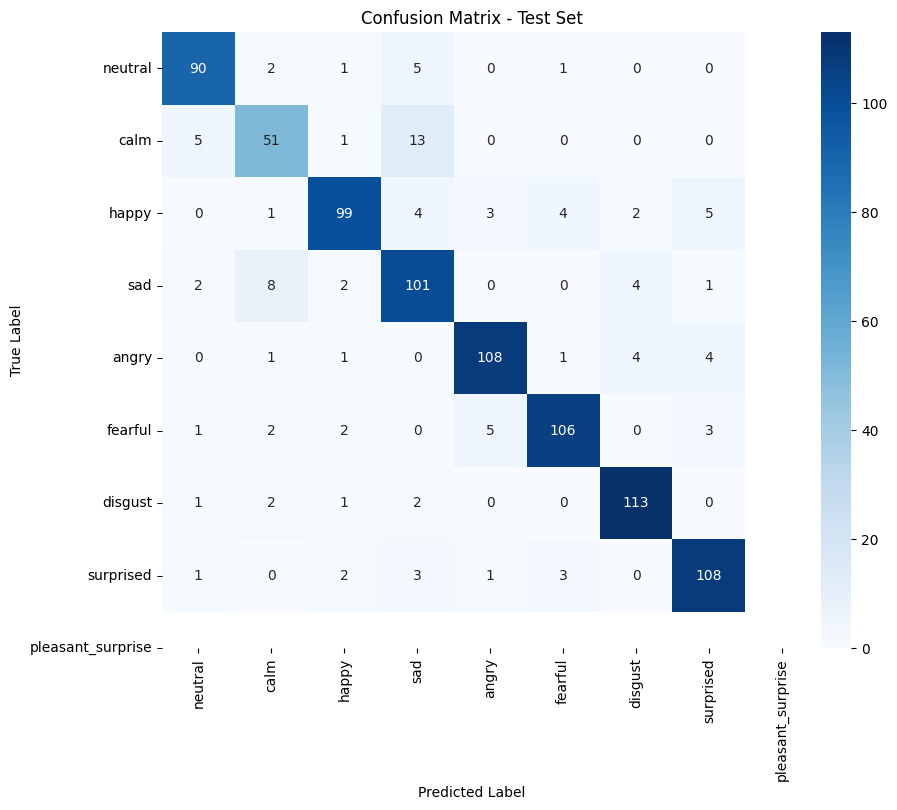

In [ ]:
# Test Set Confusion Matrix

from sklearn.metrics import confusion_matrix

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

predictions = model1.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

110/110 [==============================] - 1s 12ms/step


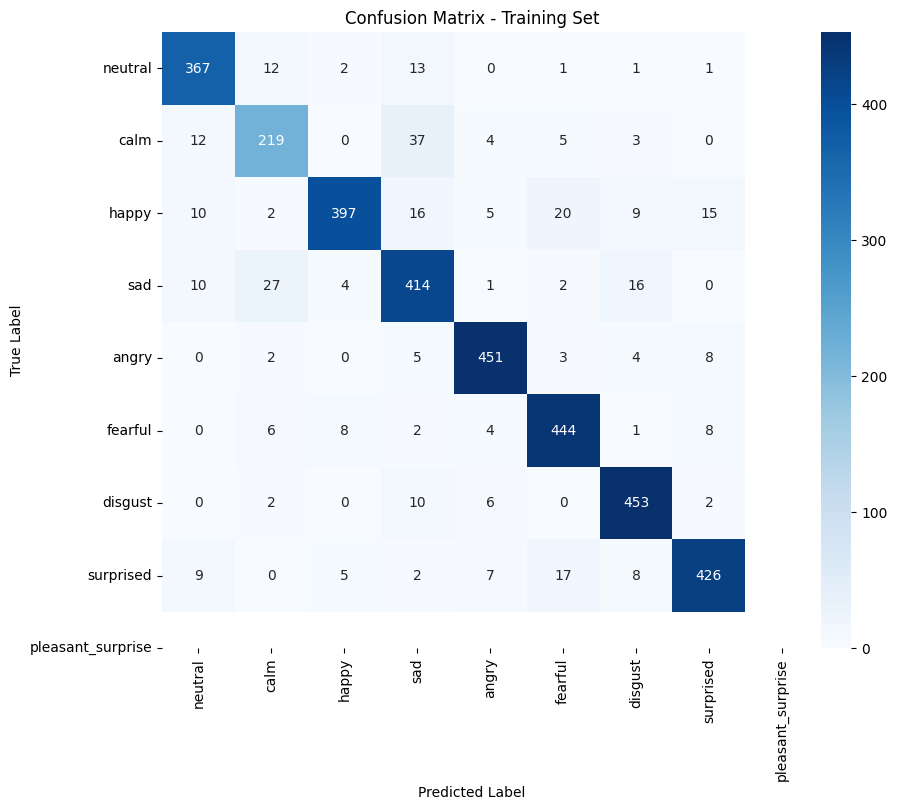

In [ ]:
# Train Set Confusion Matrix

from sklearn.metrics import confusion_matrix

true_labels = np.concatenate([y for x, y in train_ds], axis=0)

predictions = model1.predict(train_ds)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Training Set')
plt.show()

## Model2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Reshape, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(N_MELS, int(SR * DURATION / 512) + 1, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Reshape((-1, 64)),   # reshape for GRU (time_steps, features)

    LSTM(128, return_sequences=False),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(len(class_names), activation='softmax')  # for multiclass classification
])

model2.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 94, 32)        320       
                                                                 
 batch_normalization_20 (Bat  (None, 64, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 32, 47, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 47, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 32, 47, 64)     

In [ ]:
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Training
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1

)

Epoch 1/100
110/110 [==============================] - 9s 53ms/step - loss: 2.0867 - accuracy: 0.2192 - val_loss: 3.5382 - val_accuracy: 0.0795 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 5s 45ms/step - loss: 1.7077 - accuracy: 0.3812 - val_loss: 4.0635 - val_accuracy: 0.0795 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 5s 47ms/step - loss: 1.4694 - accuracy: 0.4690 - val_loss: 3.9559 - val_accuracy: 0.0795 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 5s 46ms/step - loss: 1.3190 - accuracy: 0.5395 - val_loss: 3.3654 - val_accuracy: 0.0943 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 6s 50ms/step - loss: 1.2024 - accuracy: 0.5853 - val_loss: 3.5040 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 6/100
110/110 [==============================] - 6s 50ms/step - loss: 1.1224 - accuracy: 0.6117 - val_loss: 1.4695 - val_accuracy: 0.4864 - lr: 0.0010
Epoch 7/100
110/110 [==============================] - 5s 

In [ ]:
# Save Model
model2.save('D:\JN\Multimodal Expression\Audio\emotion_audio_m2.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Load the model
"""model3 = tf.keras.models.load_model('D:\JN\Multimodal Expression\Audio\emotion_audio_m3.h5')
print("Model 'emotion_audio_m1.h5' loaded successfully!")

# Optional: Display model summary to verify
model3.summary()"""

Model 'emotion_audio_m1.h5' loaded successfully!
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 94, 16)        160       
                                                                 
 batch_normalization_10 (Bat  (None, 64, 94, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 21, 31, 16)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 21, 31, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 31, 32)        4640      
                                                                 
 batc

In [ ]:
train_loss, train_acc = model2.evaluate(train_ds, verbose=1)
print(f"✅ Train Loss: {train_loss:.4f}")
print(f"✅ Train Accuracy: {train_acc:.4f}")

test_loss, test_acc = model2.evaluate(val_ds, verbose=1)
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

110/110 [==============================] - 2s 17ms/step - loss: 0.3054 - accuracy: 0.9031
✅ Train Loss: 0.3054
✅ Train Accuracy: 0.9031
28/28 [==============================] - 0s 17ms/step - loss: 0.5728 - accuracy: 0.8114
✅ Test Loss: 0.5728
✅ Test Accuracy: 0.8114


In [ ]:
# Classification Report for Test Set

from sklearn.metrics import classification_report

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

predictions = model2.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

unique_labels = np.unique(true_labels)

target_names_subset = [class_names[i] for i in unique_labels]

# Calculate and print classification report
report = classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=target_names_subset)
print("Classification Report:")
print(report)

28/28 [==============================] - 1s 15ms/step
Classification Report:
              precision    recall  f1-score   support

     neutral       0.86      0.87      0.86        99
        calm       0.66      0.89      0.76        70
       happy       0.81      0.76      0.79       118
         sad       0.75      0.76      0.76       118
       angry       0.89      0.84      0.87       119
     fearful       0.81      0.76      0.78       119
     disgust       0.83      0.86      0.84       119
   surprised       0.86      0.80      0.83       118

    accuracy                           0.81       880
   macro avg       0.81      0.82      0.81       880
weighted avg       0.82      0.81      0.81       880



In [ ]:
# Classification Report for Train Set

train_true_labels = np.concatenate([y for x, y in train_ds], axis=0)

train_predictions = model2.predict(train_ds)
train_predicted_labels = np.argmax(train_predictions, axis=1)

train_unique_labels = np.unique(train_true_labels)

train_target_names_subset = [class_names[i] for i in train_unique_labels]

train_report = classification_report(train_true_labels, train_predicted_labels, labels=train_unique_labels, target_names=train_target_names_subset)
print("Classification Report on Training Set:")
print(train_report)

110/110 [==============================] - 2s 14ms/step
Classification Report on Training Set:
              precision    recall  f1-score   support

     neutral       0.89      0.90      0.89       397
        calm       0.76      0.96      0.85       280
       happy       0.93      0.82      0.87       474
         sad       0.90      0.86      0.88       474
       angry       0.92      0.95      0.93       473
     fearful       0.90      0.93      0.91       473
     disgust       0.96      0.96      0.96       473
   surprised       0.93      0.88      0.91       474

    accuracy                           0.90      3518
   macro avg       0.90      0.91      0.90      3518
weighted avg       0.91      0.90      0.90      3518



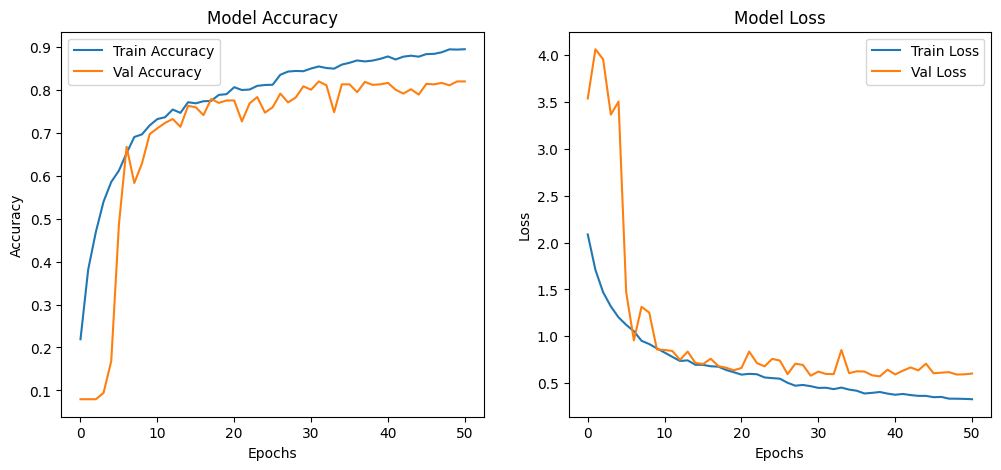

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

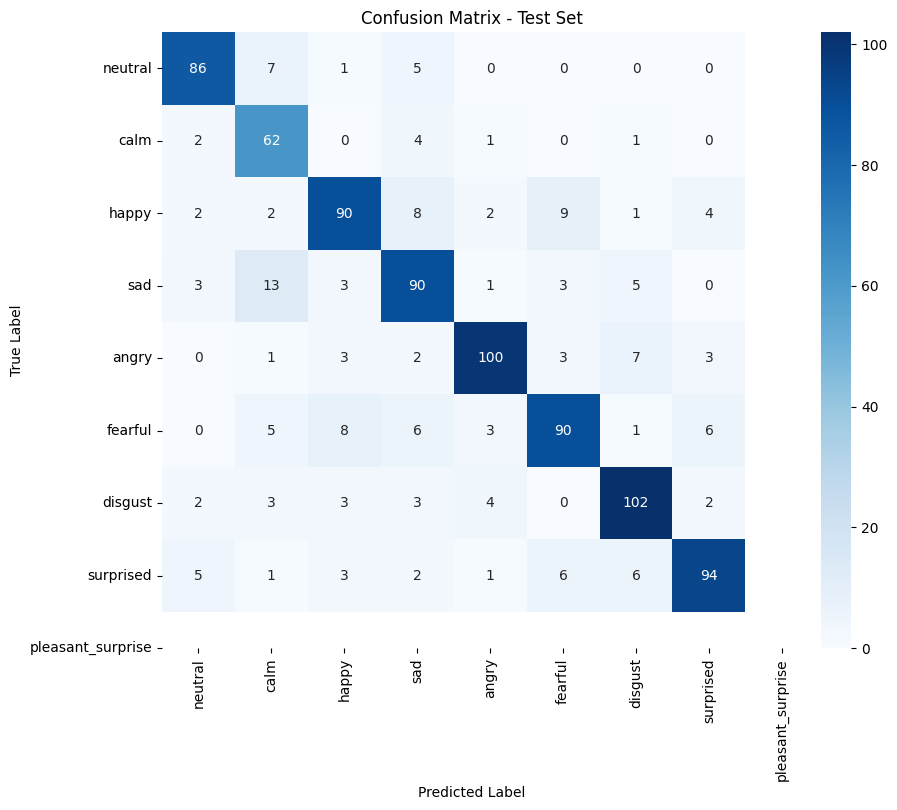

In [ ]:
# Test Set Confusion Matrix

from sklearn.metrics import confusion_matrix

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

#predictions = model3.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

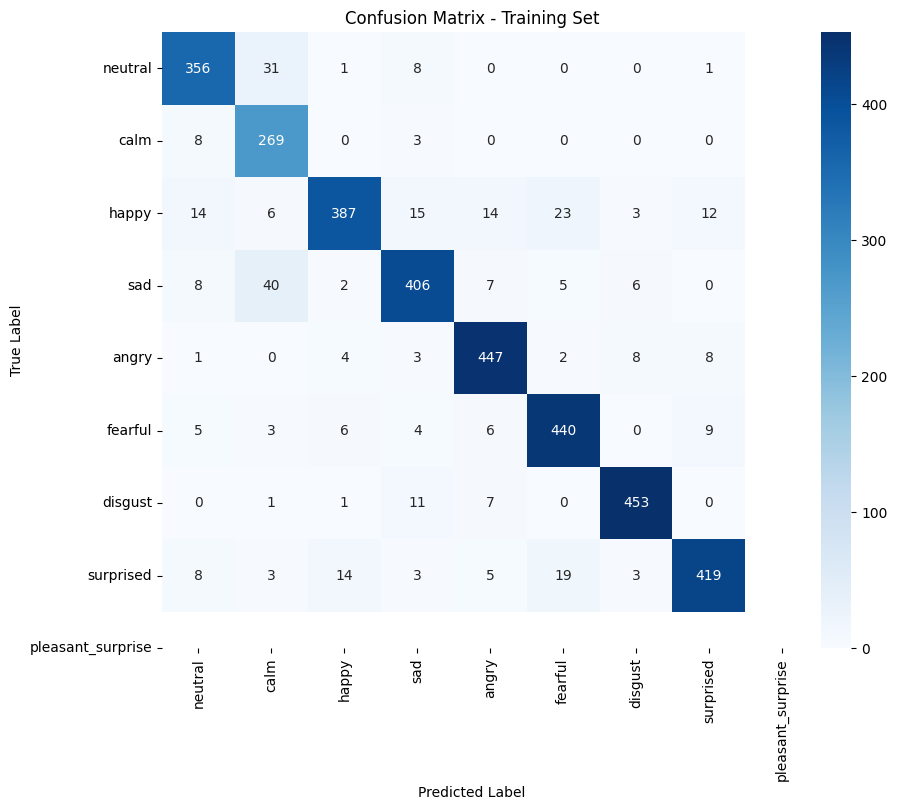

In [ ]:
# Train Set Confusion Matrix

from sklearn.metrics import confusion_matrix

true_labels = np.concatenate([y for x, y in train_ds], axis=0)

#train_predictions = model1.predict(train_ds)
train_predicted_labels = np.argmax(train_predictions, axis=1)

cm = confusion_matrix(true_labels, train_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Training Set')
plt.show()

## Model 3

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, LSTM, GlobalAveragePooling1D, Dense

model3 = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=(64, 94, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.3),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.3),

    Reshape((70, 32)),  # 7*10 = 70 time steps, 32 features

    LSTM(64, return_sequences=True),

    GlobalAveragePooling1D(),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(9, activation='softmax')  # 9 emotion classes
])

# Compile
model3.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model3.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 94, 16)        160       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 94, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 21, 31, 16)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 21, 31, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 31, 32)        4640      
                                                                 
 batch_normalization_7 (Batc  (None, 21, 31, 32)      

In [ ]:
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Training
history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1

)

Epoch 1/100
110/110 [==============================] - 78s 670ms/step - loss: 1.9089 - accuracy: 0.2464 - val_loss: 2.1838 - val_accuracy: 0.1443 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 2s 14ms/step - loss: 1.4903 - accuracy: 0.4085 - val_loss: 2.1769 - val_accuracy: 0.1330 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 2s 14ms/step - loss: 1.2816 - accuracy: 0.5185 - val_loss: 2.2515 - val_accuracy: 0.1239 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 2s 14ms/step - loss: 1.1611 - accuracy: 0.5654 - val_loss: 3.9933 - val_accuracy: 0.1148 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 2s 14ms/step - loss: 1.0520 - accuracy: 0.6026 - val_loss: 4.1851 - val_accuracy: 0.1295 - lr: 0.0010
Epoch 6/100
110/110 [==============================] - 2s 14ms/step - loss: 1.0009 - accuracy: 0.6171 - val_loss: 3.0907 - val_accuracy: 0.2477 - lr: 0.0010
Epoch 7/100
110/110 [==============================] - 2

In [ ]:
# Save Model
"""model3.save('D:\JN\Multimodal Expression\Audio\emotion_audio_m3a.h5')
print("Model saved successfully!")"""

Model saved successfully!


In [ ]:
# Load the model
"""model3 = tf.keras.models.load_model('D:\JN\Multimodal Expression\Audio\emotion_audio_m3.h5')
print("Model 'emotion_audio_m1.h5' loaded successfully!")

# Optional: Display model summary to verify
model3.summary()"""

Model 'emotion_audio_m1.h5' loaded successfully!
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 94, 16)        160       
                                                                 
 batch_normalization_10 (Bat  (None, 64, 94, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 21, 31, 16)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 21, 31, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 31, 32)        4640      
                                                                 
 batc

In [ ]:
train_loss, train_acc = model3.evaluate(train_ds, verbose=1)
print(f"✅ Train Loss: {train_loss:.4f}")
print(f"✅ Train Accuracy: {train_acc:.4f}")

test_loss, test_acc = model3.evaluate(val_ds, verbose=1)
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

110/110 [==============================] - 1s 9ms/step - loss: 0.3345 - accuracy: 0.8761
✅ Train Loss: 0.3345
✅ Train Accuracy: 0.8761
28/28 [==============================] - 0s 7ms/step - loss: 0.4583 - accuracy: 0.8443
✅ Test Loss: 0.4583
✅ Test Accuracy: 0.8443


In [ ]:
# Classification Report for Test Set

from sklearn.metrics import classification_report

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

predictions = model3.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

unique_labels = np.unique(true_labels)

target_names_subset = [class_names[i] for i in unique_labels]

# Calculate and print classification report
report = classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=target_names_subset)
print("Classification Report:")
print(report)

28/28 [==============================] - 1s 14ms/step
Classification Report:
              precision    recall  f1-score   support

     neutral       0.83      0.88      0.85        99
        calm       0.67      0.93      0.78        70
       happy       0.98      0.71      0.82       118
         sad       0.82      0.76      0.79       118
       angry       0.85      0.86      0.85       119
     fearful       0.87      0.82      0.84       119
     disgust       0.86      0.91      0.88       119
   surprised       0.89      0.92      0.90       118

    accuracy                           0.84       880
   macro avg       0.84      0.85      0.84       880
weighted avg       0.85      0.84      0.84       880



In [ ]:
# Classification Report for Train Set

train_true_labels = np.concatenate([y for x, y in train_ds], axis=0)

train_predictions = model3.predict(train_ds)
train_predicted_labels = np.argmax(train_predictions, axis=1)

train_unique_labels = np.unique(train_true_labels)

train_target_names_subset = [class_names[i] for i in train_unique_labels]

train_report = classification_report(train_true_labels, train_predicted_labels, labels=train_unique_labels, target_names=train_target_names_subset)
print("Classification Report on Training Set:")
print(train_report)

110/110 [==============================] - 1s 8ms/step
Classification Report on Training Set:
              precision    recall  f1-score   support

     neutral       0.90      0.90      0.90       397
        calm       0.70      0.97      0.81       280
       happy       0.95      0.73      0.82       474
         sad       0.86      0.78      0.82       474
       angry       0.89      0.92      0.90       473
     fearful       0.88      0.90      0.89       473
     disgust       0.91      0.90      0.91       473
   surprised       0.92      0.95      0.93       474

    accuracy                           0.88      3518
   macro avg       0.87      0.88      0.87      3518
weighted avg       0.88      0.88      0.88      3518



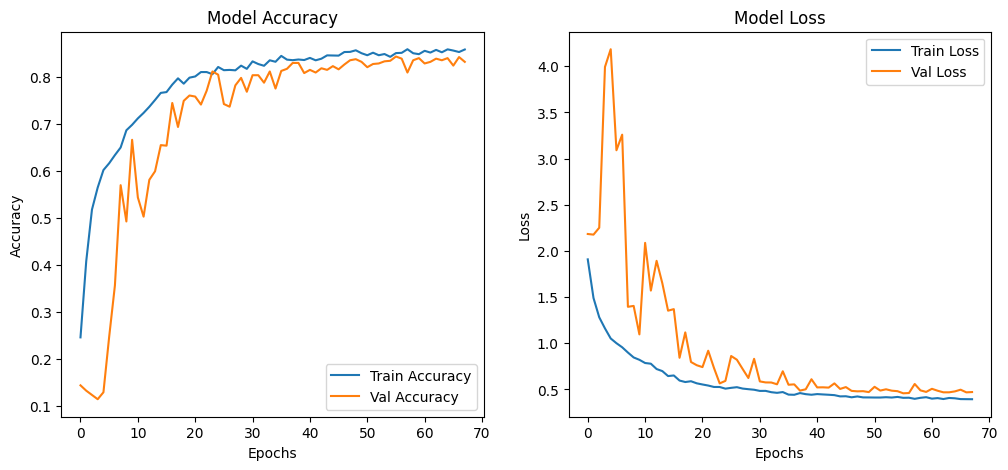

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

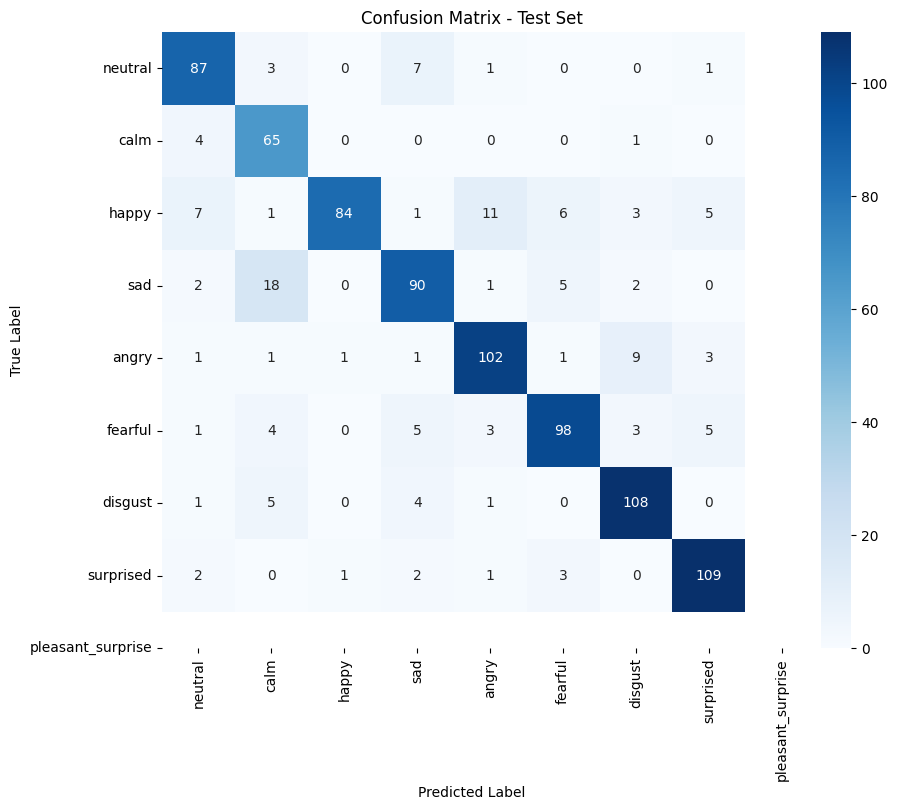

In [ ]:
# Test Set Confusion Matrix

from sklearn.metrics import confusion_matrix

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

#predictions = model3.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

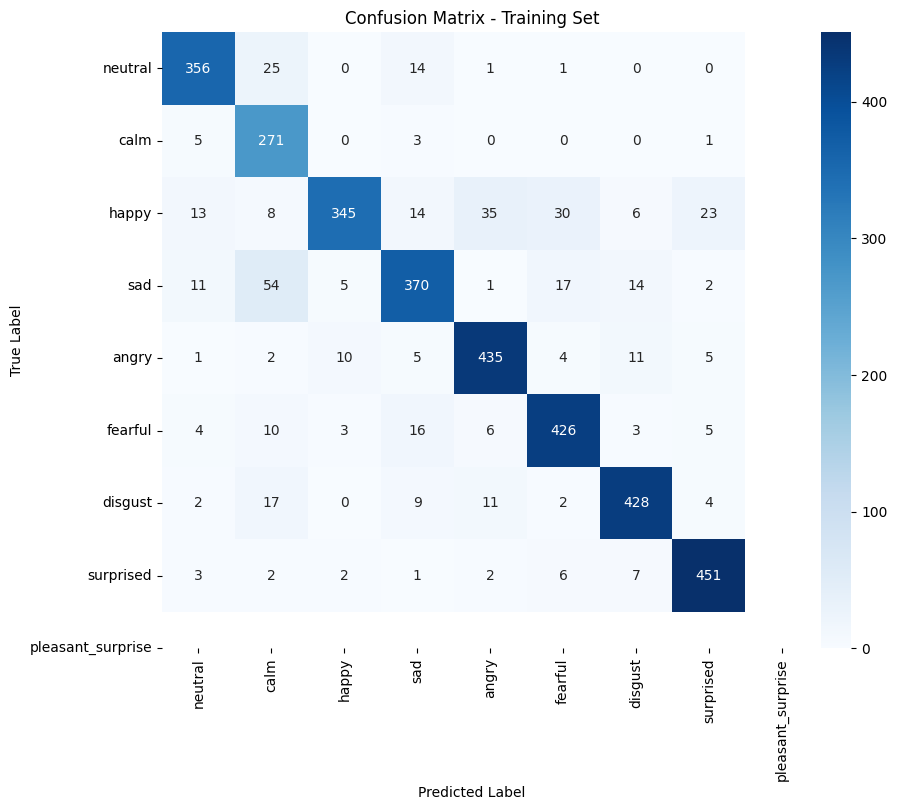

In [ ]:
# Train Set Confusion Matrix

from sklearn.metrics import confusion_matrix

true_labels = np.concatenate([y for x, y in train_ds], axis=0)

#train_predictions = model1.predict(train_ds)
train_predicted_labels = np.argmax(train_predictions, axis=1)

cm = confusion_matrix(true_labels, train_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Training Set')
plt.show()

## Model 4

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Reshape, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same',
           input_shape=(N_MELS, int(SR * DURATION / 512) + 1, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Reshape((-1, 64)),   # (time_steps, features)

    LSTM(128, return_sequences=False, dropout=0.3),
    #LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    #LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),

    Dense(len(class_names), activation='softmax')
])

model4.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 64, 94, 32)        320       
                                                                 
 batch_normalization_16 (Bat  (None, 64, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 32, 47, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 47, 64)        18496     
                                                                 
 batch_normalization_17 (Bat  (None, 32, 47, 64)      

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Reshape, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Model
model4 = Sequential([
    # ---- CNN Block 1 ----
    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(N_MELS, int(SR * DURATION / 512) + 1, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # ---- CNN Block 2 ----
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # ---- Reshape for LSTM ----
    Reshape((-1, 64)),  # (time_steps, features)

    # ---- LSTM Block ----
    LSTM(128, return_sequences=False, dropout=0.3),  # CuDNN-compatible (no recurrent_dropout!)

    # ---- Dense Layers ----
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),

    # ---- Output Layer ----
    Dense(len(class_names), activation='softmax', kernel_regularizer=regularizers.l2(0.001))
])

# Compile
model4.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model4.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 94, 32)        320       
                                                                 
 batch_normalization_18 (Bat  (None, 64, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 47, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 32, 47, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 47, 64)        18496     
                                                                 
 batch_normalization_19 (Bat  (None, 32, 47, 64)      

In [ ]:
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Training
history4 = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1

)

Epoch 1/100
110/110 [==============================] - 9s 55ms/step - loss: 2.1323 - accuracy: 0.2143 - val_loss: 3.2590 - val_accuracy: 0.0795 - lr: 0.0010
Epoch 2/100
110/110 [==============================] - 7s 68ms/step - loss: 1.7866 - accuracy: 0.3593 - val_loss: 3.6219 - val_accuracy: 0.0795 - lr: 0.0010
Epoch 3/100
110/110 [==============================] - 12s 106ms/step - loss: 1.5494 - accuracy: 0.4670 - val_loss: 3.4879 - val_accuracy: 0.0795 - lr: 0.0010
Epoch 4/100
110/110 [==============================] - 12s 107ms/step - loss: 1.4397 - accuracy: 0.4997 - val_loss: 3.3026 - val_accuracy: 0.1034 - lr: 0.0010
Epoch 5/100
110/110 [==============================] - 9s 81ms/step - loss: 1.3142 - accuracy: 0.5480 - val_loss: 3.7067 - val_accuracy: 0.1614 - lr: 0.0010
Epoch 6/100
110/110 [==============================] - 10s 93ms/step - loss: 1.2262 - accuracy: 0.5819 - val_loss: 1.7423 - val_accuracy: 0.4205 - lr: 0.0010
Epoch 7/100
110/110 [==============================] 

In [ ]:
""""model4.save('D:\JN\Multimodal Expression\Audio\emotion_audio_m4.h5')
print("Model saved successfully!")""""

In [ ]:
# Load the model
model4 = tf.keras.models.load_model('D:\JN\Multimodal Expression\Audio\emotion_audio_m4.h5')
print("Model loaded successfully!")

# Optional: Display model summary to verify
model4.summary()

Model 'emotion_audio_m1.h5' loaded successfully!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 94, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 47, 64)        18496     
                                                                 
 batch_

In [ ]:
train_loss, train_acc = model4.evaluate(train_ds, verbose=1)
print(f"✅ Train Loss: {train_loss:.4f}")
print(f"✅ Train Accuracy: {train_acc:.4f}")

test_loss, test_acc = model4.evaluate(val_ds, verbose=1)
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

110/110 [==============================] - 3s 27ms/step - loss: 0.3340 - accuracy: 0.9167
✅ Train Loss: 0.3340
✅ Train Accuracy: 0.9167
28/28 [==============================] - 1s 48ms/step - loss: 0.6237 - accuracy: 0.8295
✅ Test Loss: 0.6237
✅ Test Accuracy: 0.8295


In [ ]:
# Classification Report for Test Set

from sklearn.metrics import classification_report

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

predictions = model4.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

unique_labels = np.unique(true_labels)

target_names_subset = [class_names[i] for i in unique_labels]

# Calculate and print classification report
report = classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=target_names_subset)
print("Classification Report:")
print(report)

28/28 [==============================] - 2s 30ms/step
Classification Report:
              precision    recall  f1-score   support

     neutral       0.90      0.91      0.90        99
        calm       0.69      0.94      0.80        70
       happy       0.80      0.82      0.81       118
         sad       0.89      0.76      0.82       118
       angry       0.92      0.81      0.86       119
     fearful       0.88      0.76      0.81       119
     disgust       0.80      0.87      0.83       119
   surprised       0.77      0.83      0.80       118

    accuracy                           0.83       880
   macro avg       0.83      0.84      0.83       880
weighted avg       0.84      0.83      0.83       880



In [ ]:
# Classification Report for Train Set

train_true_labels = np.concatenate([y for x, y in train_ds], axis=0)

train_predictions = model4.predict(train_ds)
train_predicted_labels = np.argmax(train_predictions, axis=1)

train_unique_labels = np.unique(train_true_labels)

train_target_names_subset = [class_names[i] for i in train_unique_labels]

train_report = classification_report(train_true_labels, train_predicted_labels, labels=train_unique_labels, target_names=train_target_names_subset)
print("Classification Report on Training Set:")
print(train_report)

110/110 [==============================] - 3s 31ms/step
Classification Report on Training Set:
              precision    recall  f1-score   support

     neutral       0.91      0.95      0.93       397
        calm       0.84      0.97      0.90       280
       happy       0.92      0.88      0.90       474
         sad       0.94      0.84      0.89       474
       angry       0.98      0.90      0.93       473
     fearful       0.95      0.92      0.93       473
     disgust       0.92      0.98      0.95       473
   surprised       0.87      0.93      0.90       474

    accuracy                           0.92      3518
   macro avg       0.91      0.92      0.92      3518
weighted avg       0.92      0.92      0.92      3518



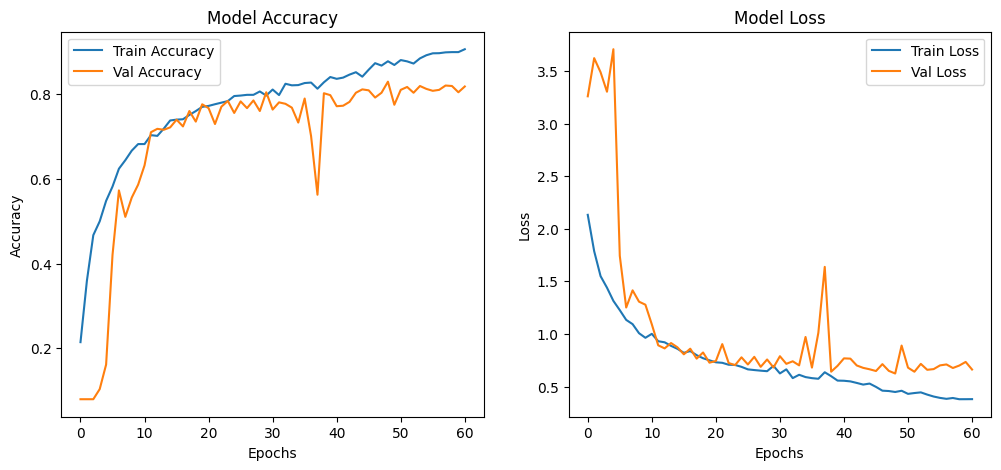

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

28/28 [==============================] - 1s 31ms/step


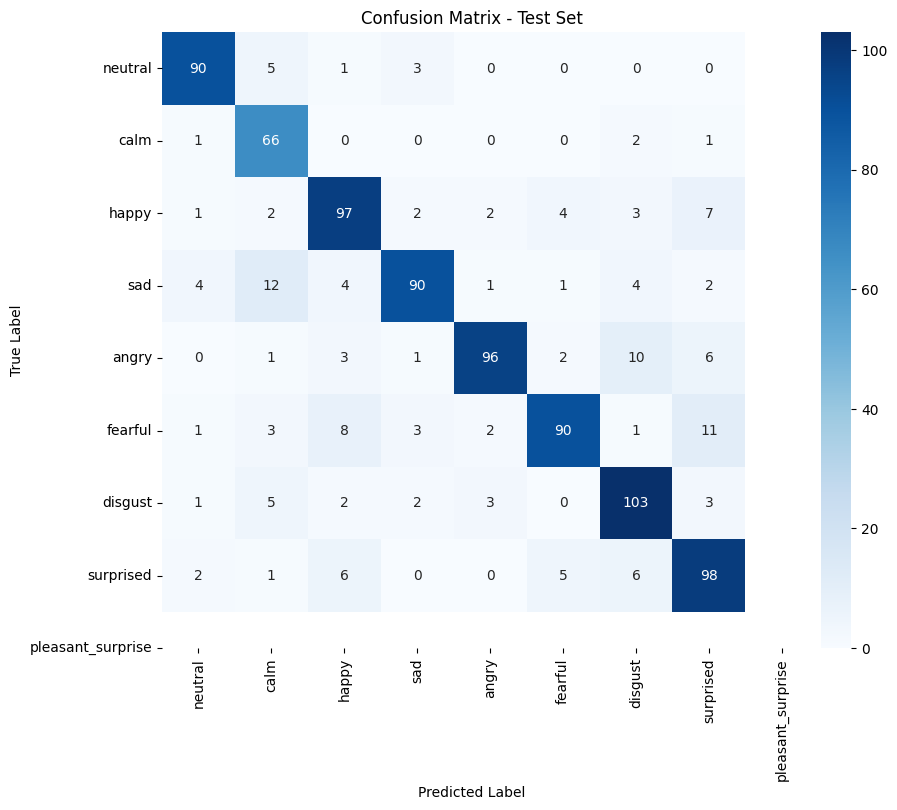

In [ ]:
# Test Set Confusion Matrix

from sklearn.metrics import confusion_matrix

true_labels = np.concatenate([y for x, y in val_ds], axis=0)

predictions = model4.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

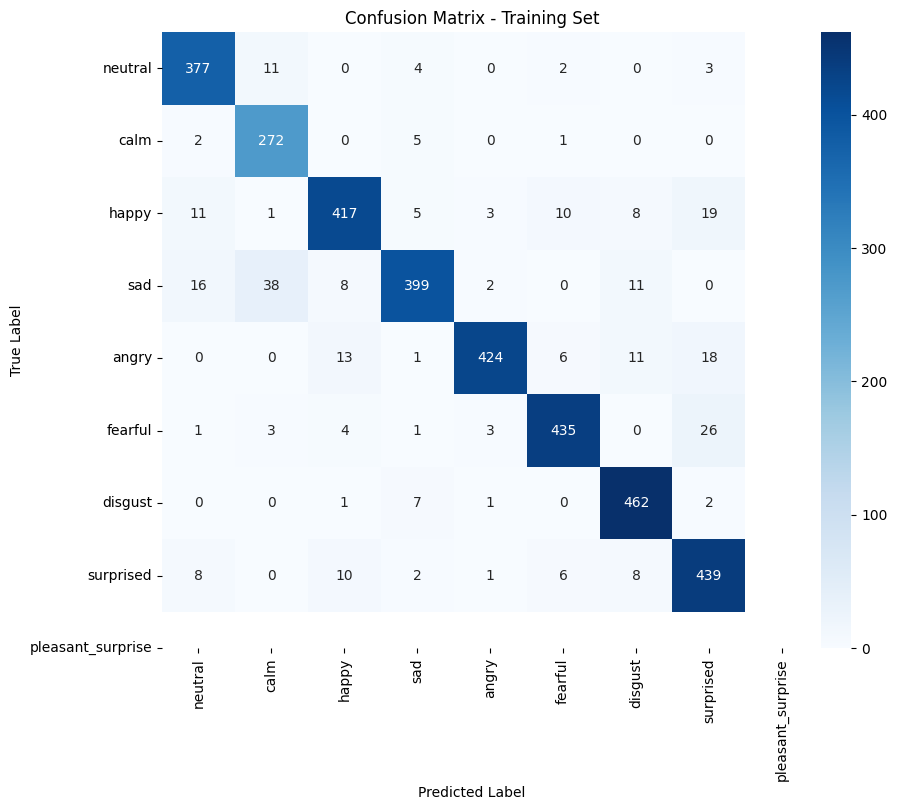

In [ ]:
# Train Set Confusion Matrix

from sklearn.metrics import confusion_matrix

true_labels = np.concatenate([y for x, y in train_ds], axis=0)

#train_predictions = model4.predict(train_ds)
train_predicted_labels = np.argmax(train_predictions, axis=1)

cm = confusion_matrix(true_labels, train_predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Training Set')
plt.show()